Load necessary libraries.

In [36]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### ML packages
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import umap
from sklearn.decomposition import FastICA, NMF, KernelPCA, PCA

#Msc
import warnings

Load dataset.

In [37]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)
authors = df['Author'].values  # n_samples-length array

# K-Means ++

In [38]:
X = X.to_numpy() # change pd.DataFrame to np.ndarray

K-means ++ below.

In [39]:
k = 4 
# number of clusters (assuming we know this - distinct authors = 4)
# we can hyperparameter tune if unknown (in real setting)
# will do validation later in repository

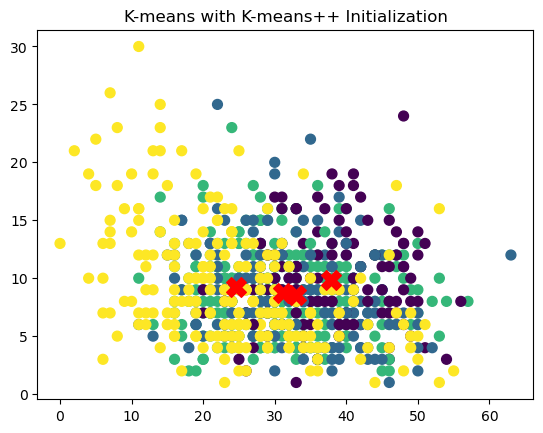

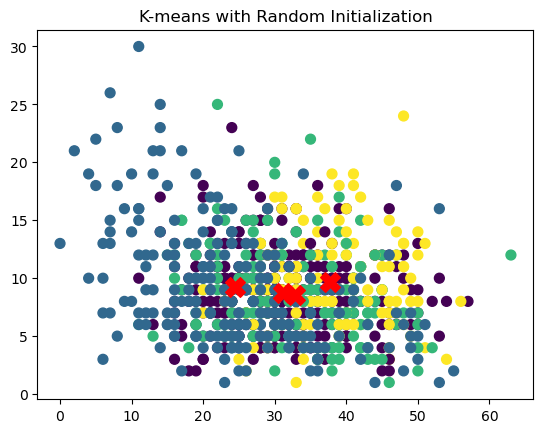

In [40]:
# K-means++ initialization 
kmeans_pp = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans_pp.fit(X)
y_kmeans_pp = kmeans_pp.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans_pp, s=50, cmap='viridis')
centers_pp = kmeans_pp.cluster_centers_
plt.scatter(centers_pp[:, 0], centers_pp[:, 1], c='red', s=200, marker='X')
plt.title('K-means with K-means++ Initialization')
plt.show()

# K-means w/ random initialization
kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis') # plot
centers = kmeans.cluster_centers_ # centroids
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X') # plot centroids
plt.title('K-means with Random Initialization')
plt.show()

The results are poor, clearly some type of dimensionality reduction should be applied before running k-means++.  Lets apply UMAP and rerun K-means++.

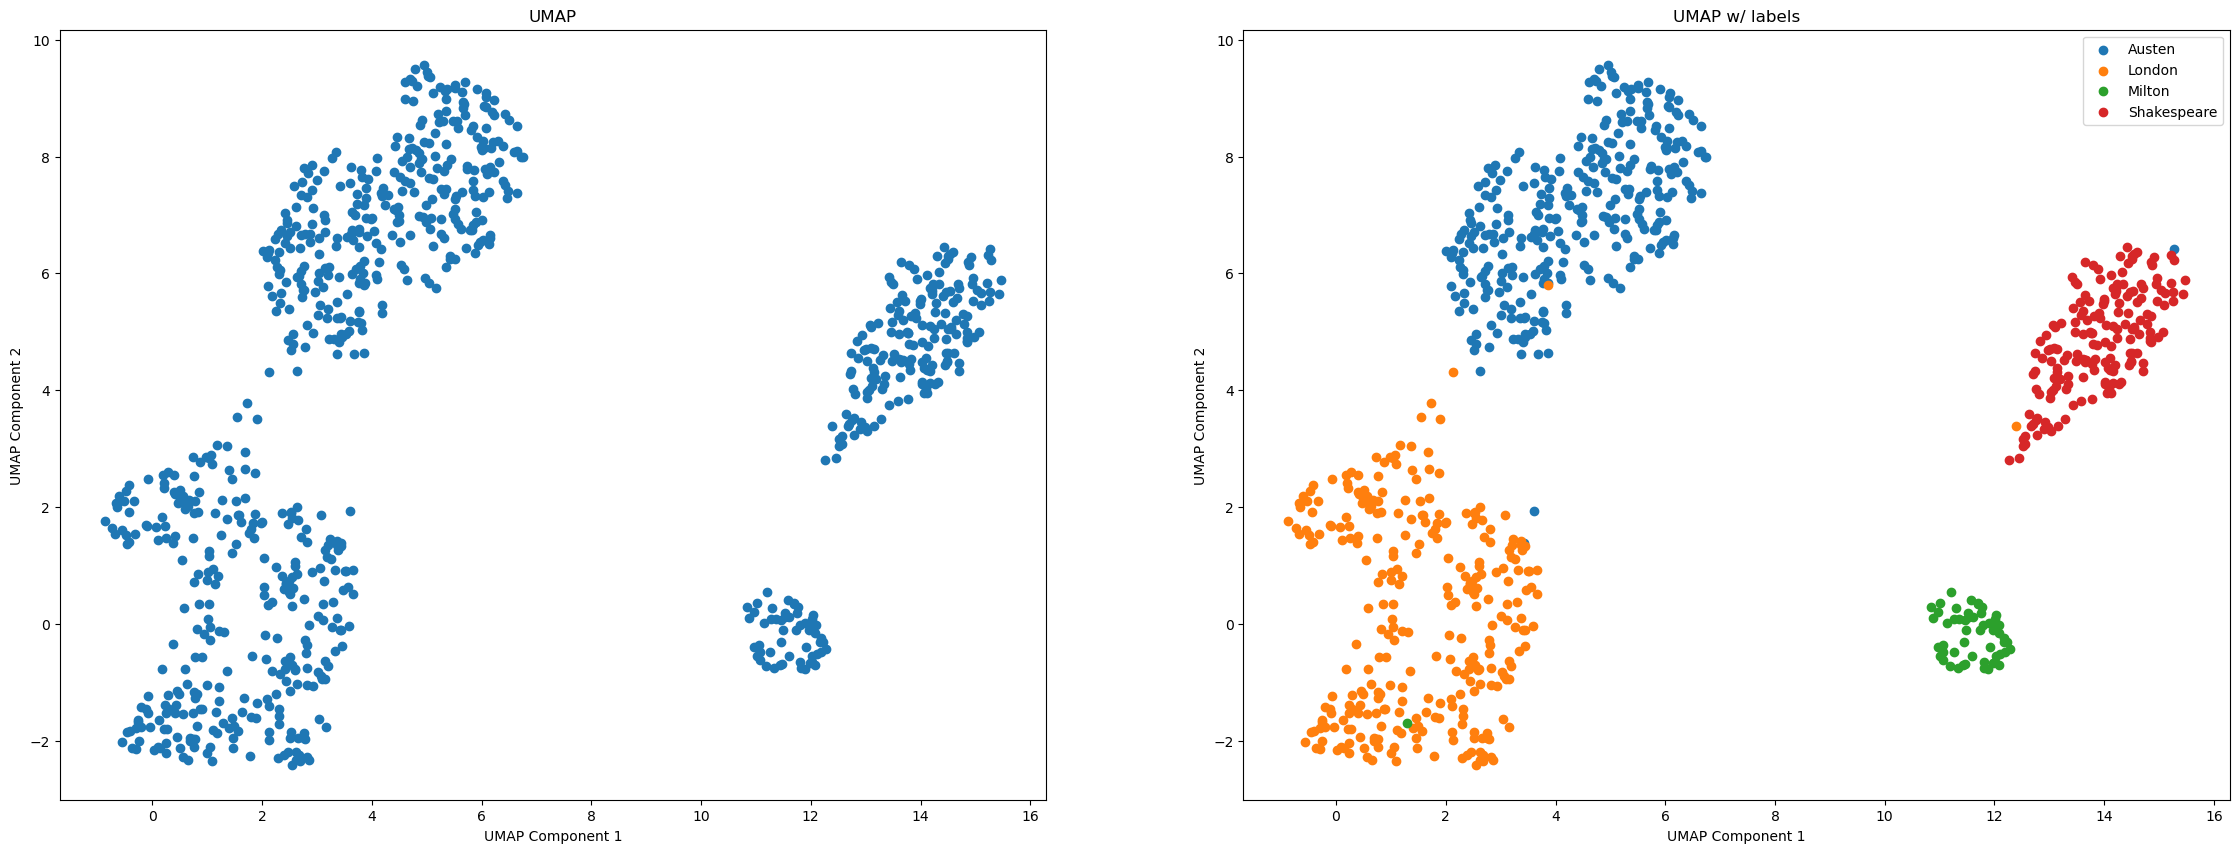

In [41]:
### UMAP
warnings.filterwarnings("ignore", category=UserWarning, module="umap") # Suppress the specific UMAP warning on parralelism
random_state = 42 # reproducibility for analysis
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=random_state);
X_umap = umap_model.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(28, 10))

axes[0].scatter(X_umap[:,0],X_umap[:,1])
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")
axes[0].set_title("UMAP")

for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
axes[1].legend(loc="upper right")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")
axes[1].set_title("UMAP w/ labels");



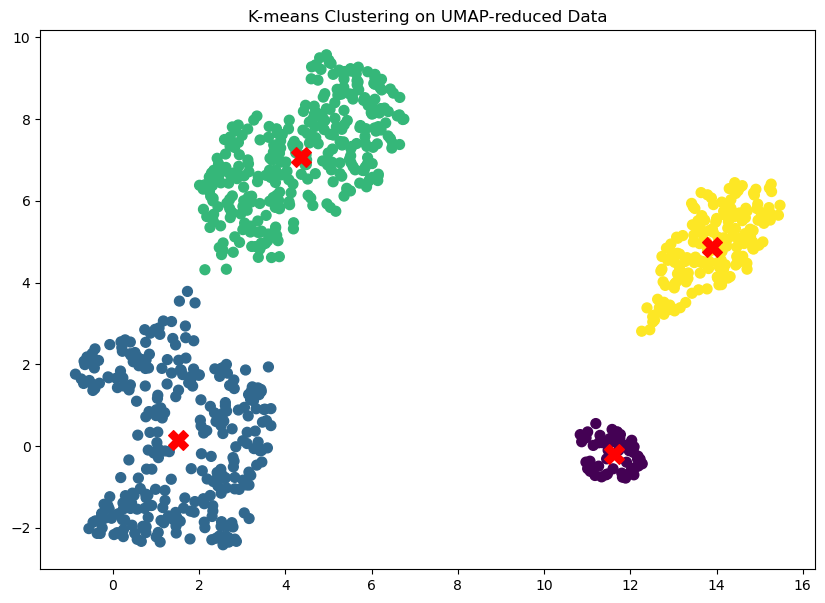

In [42]:
# Run K-means++ on UMAP-reduced data
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X_umap)

y_kmeans = kmeans.predict(X_umap) # Predict clusters

plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')  # Plot centroids
plt.title('K-means Clustering on UMAP-reduced Data')
plt.show()

This is looking a lot better! Now, assuming we didnt have the author labels, we could pull out the labels from the K-means++ and inspect which chapters correspond to which cluster!

In [43]:
centroids = kmeans.cluster_centers_ # Get the centroids of the clusters
print(centroids) # Output the centroids

# Looking at the clusters and our labels from UMAP w/ labels, the following mapping is provided.
cluster_mapping = {'Milton':0, 'London':1, 'Austen':2, 'Shakespeare':3}
print(f'\nMapping: {cluster_mapping}')

[[11.616457   -0.19323611]
 [ 1.5033488   0.14024258]
 [ 4.358289    7.0590777 ]
 [13.906439    4.8637104 ]]

Mapping: {'Milton': 0, 'London': 1, 'Austen': 2, 'Shakespeare': 3}


In [44]:
labels = kmeans.labels_
labels_df = pd.DataFrame(labels).reset_index(drop=False).rename(columns = {'index':'Chapters', 0:'Cluster/Author'})
labels_df['Author'] = df['Author'].values

bool_ = []
for i in range(labels_df.shape[0]):
    if cluster_mapping[labels_df.iloc[i,2]] == labels_df.iloc[i,1]:
        bool_.append(True)
    else:
        bool_.append(False)
labels_df['Correct?'] = bool_
labels_df

,Chapters,Cluster/Author,Author,Correct?
0,0,2,Austen,True
1,1,2,Austen,True
2,2,2,Austen,True
3,3,2,Austen,True
4,4,2,Austen,True
...,...,...,...,...
836,836,3,Shakespeare,True
837,837,3,Shakespeare,True
838,838,3,Shakespeare,True
839,839,3,Shakespeare,True


Lets report our clustering accuracy for K-means ++ using UMAP dimensionality reduction.

In [45]:
print(f'Accuracy = {round(labels_df['Correct?'].mean(),5)}\nMeaning that {round(labels_df['Correct?'].mean(),5)*100}% of the chapters were correctly assigned to the correct author.')

Accuracy = 0.99168
Meaning that 99.168% of the chapters were correctly assigned to the correct author.


Lets save this accuracy into a dictionary and compare it with other clustering methods!

In [46]:
method_accuracy = {}
method_accuracy['kmeans'] = labels_df['Correct?'].mean()

# Hierarchical Clustering

In [47]:
# insert

# Gaussian Mixture Models

In [48]:
# insert

# Spectral Clustering

In [49]:
# insert